In [40]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [41]:
import pandas as pd

df = pd.read_csv('data.csv', sep =';')
print(df.columns.tolist())

['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Target']


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


df_filtered = df[df['Target'].isin(['Dropout', 'Graduate'])].copy()
df_filtered['Target'] = df_filtered['Target'].map({'Dropout': 0, 'Graduate': 1})



selected_features = ['Admission grade', 'Previous qualification (grade)']
X = df_filtered[selected_features].copy()
y = df_filtered['Target']



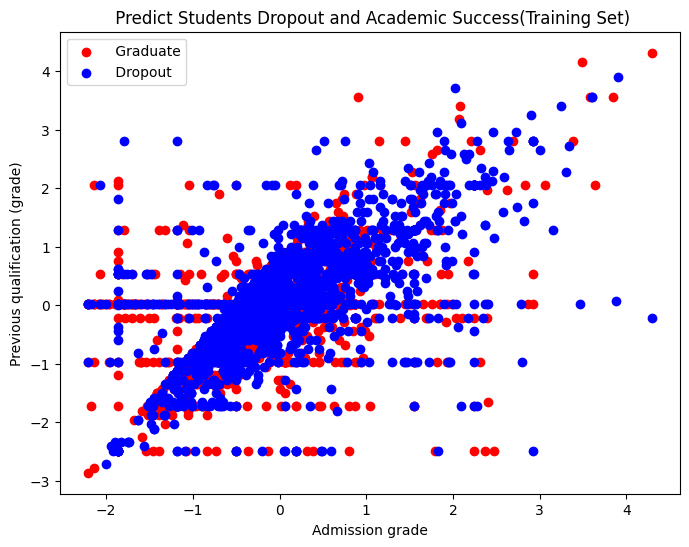

In [43]:
# we will only take two features for visualization purposes
#X = df[['Previous qualification (grade)', 'Focus_pct']].values  # StudyTime_hrs and Focus_pct

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
#Data Standardization:
#The data is scaled so that its mean is 0 and its variance is 1.
#This is important in logistic regression because it helps the model learn better and faster

# add bias (x_0 = 1) term to X
X_bias = np.hstack((X, np.ones((X.shape[0], 1))))
#Adding Bias:
#In logistic regression or perceptron, a fixed feature x₀ = 1 is usually added to all samples.
#This allows the model to also learn the bias value (intercept or θ₀).
#Now the feature matrix has three columns: [feature1, feature2, bias=1]


X_train, X_val, y_train, y_val = train_test_split(
    X_bias, y, test_size=0.2, random_state=42, stratify=y
)
#Stratify=y is used to maintain the proportion of labels 0 and 1 in both sets.
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label=' Graduate')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label=' Dropout')
plt.xlabel('Admission grade')
plt.ylabel('Previous qualification (grade)')
plt.title(' Predict Students Dropout and Academic Success(Training Set)')
plt.legend()
plt.show()

In [44]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(w, X, y):
    z = X @ w
    # applying the sigmoid function to get predicted probabilities
    predictions = sigmoid(z)
    # binary cross-entropy loss
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss
#The loss function is measuring:
#"How well is the model giving the correct probabilities?"
#The better the model gives the probabilities (closer to reality), the lower the loss value.
#The more wrongly it predicts (e.g., giving 0.9 to reject), the higher the loss value.


def compute_gradient(w, X, y):
    z = X @ w
    predictions = sigmoid(z)
    # error = difference between predicted and true labels
    errors = predictions - y
    # compute the gradient of the loss function
    gradient = X.T @ errors / len(y)
    return gradient

def validation_accuracy(w, X_val, y_val):
    probabilities = sigmoid(X_val @ w)
    predictions = (probabilities > 0.5).astype(int) # decission rule for binary classification
    accuracy = np.mean(predictions == y_val)
    return accuracy
    #Finally, it returns the percentage of samples that are correctly classified as accuracy.

In [45]:
def gradient_descent_logistic(X_train, y_train, X_val, y_val,
                              learning_rate=0.1, n_steps=1000, tolerance=1e-6):
    w = np.zeros(X_train.shape[1])  # start with all weights equal to 0
    # Weights (w) are initially set to zero. If we have two features + bias, for example w = [0, 0, 0].
    loss_history = [compute_loss(w, X_train, y_train)]
    val_accuracy_history = [validation_accuracy(w, X_val, y_val)]
    weights_history = [w.copy()]  # storing weights for decision boundary plotting

    for step in range(1, n_steps + 1):
        grad = compute_gradient(w, X_train, y_train)
        #"In what direction should I change the weights to reduce the loss?"
        w -= learning_rate * grad  # update rule
        #We move the weights in the opposite direction of the gradient (because we want the loss to decrease).
        loss = compute_loss(w, X_train, y_train)
        loss_history.append(loss)

        # compute validation accuracy
        acc = validation_accuracy(w, X_val, y_val)
        val_accuracy_history.append(acc)

        # storing weights every 10 steps for plotting
        if step % 10 == 0:
            weights_history.append(w.copy())

        # check convergence
        if np.abs(loss_history[-2] - loss_history[-1]) < tolerance:
            print(f'Converged at step {step}')
            break
#That is, if the loss changes very little between two consecutive steps (its change < tolerance), say:
#"The model has learned enough - that's it!"

        if step % 100 == 0:
            print(f'Step {step}: Loss = {loss:.4f}, Validation Accuracy = {acc:.4f}')

    return w, loss_history, val_accuracy_history, weights_history
#Result:
#This function trains the logistic model with gradient descent, and along the way:

#Checks the loss

#Measures the accuracy on the validation data

#Keeps the weights to draw the decision boundary

In [46]:
learning_rate = 0.05
n_steps = 800

w_opt, loss_history, val_accuracy_history, weights_history = gradient_descent_logistic(
    X_train, y_train, X_val, y_val,
    learning_rate=learning_rate,
    n_steps=n_steps,
)

print(f'Optimized weights: {w_opt}')
print(f'Decision rule: {w_opt[0]} * Admission grade + {w_opt[1]} * Previous qualification (grade) + {w_opt[2]} > 0 : Graduate')
print(f'Decision rule: {w_opt[0]} * Admission grade  + {w_opt[1]} * Previous qualification (grade) + {w_opt[2]} < 0 : Dropout')
#(First weight × First feature) + (Second weight × Second feature) + Bias > 0

Step 100: Loss = 0.6617, Validation Accuracy = 0.6061
Step 200: Loss = 0.6594, Validation Accuracy = 0.6074
Converged at step 276
Optimized weights: [0.18922774 0.14326421 0.43349156]
Decision rule: 0.18922774183096533 * Admission grade + 0.14326420912621363 * Previous qualification (grade) + 0.4334915555351876 > 0 : Graduate
Decision rule: 0.18922774183096533 * Admission grade  + 0.14326420912621363 * Previous qualification (grade) + 0.4334915555351876 < 0 : Dropout


<ipython-input-47-62cc73b17542>:9: RuntimeWarning: invalid value encountered in scalar divide
  plt.axvline(x=-w[2]/w[0], color='green')


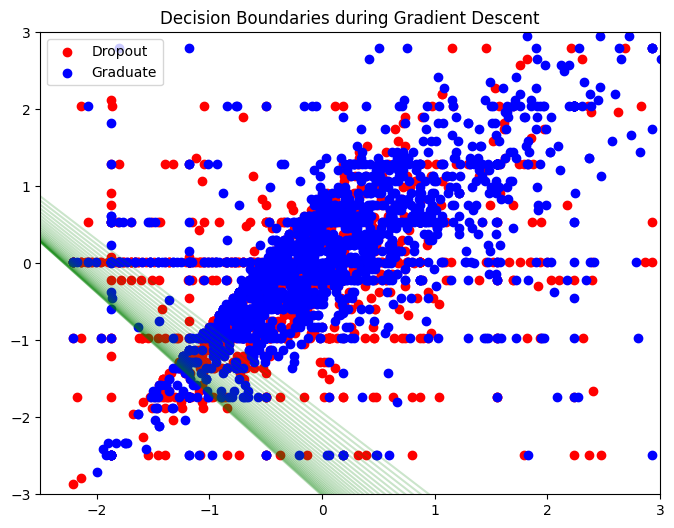

In [47]:
def plot_decision_boundary(w, X, y, step, total_steps):
    x_values = np.array([X[:, 0].min() - 1, X[:, 0].max() + 1])
    if w[1] != 0:
        y_values = -(w[0] * x_values + w[2]) / w[1]
        #This equation is a line that shows the boundary points between classes.
        plt.plot(x_values, y_values, color='green', alpha=(0.20 + (step / total_steps) * 0.20))
        #The transparency of each line is adjusted so that the initial lines appear lighter and the final lines appear darker.
    else:
        plt.axvline(x=-w[2]/w[0], color='green')
    plt.legend()

def plot_decision_boundaries(weights_history, X, y, total_steps):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Dropout')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Graduate')
    plt.xlim(-2.5, 3)
    plt.ylim(-3, 3)
    for i, w in enumerate(weights_history):
        step = i * 10
        plot_decision_boundary(w, X, y, step, total_steps)
    plt.title('Decision Boundaries during Gradient Descent')
    plt.show()

plot_decision_boundaries(weights_history, X_train[:, :2], y_train, n_steps)

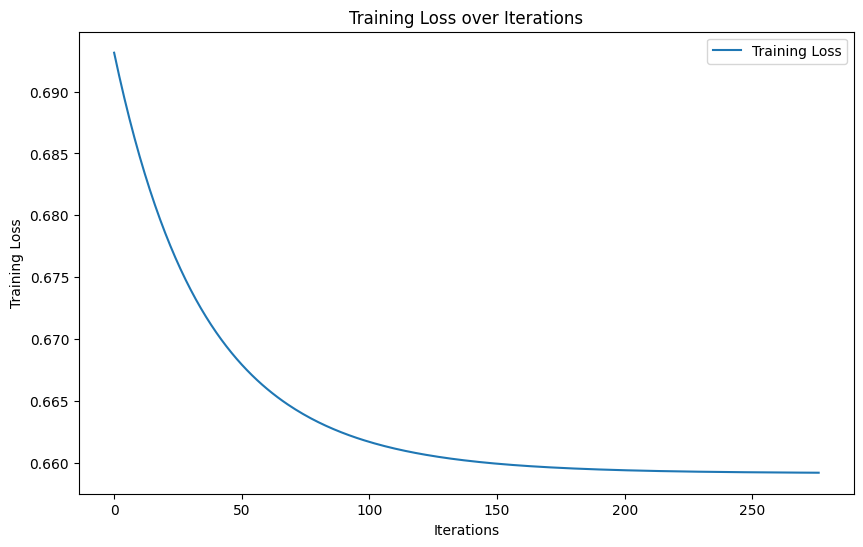

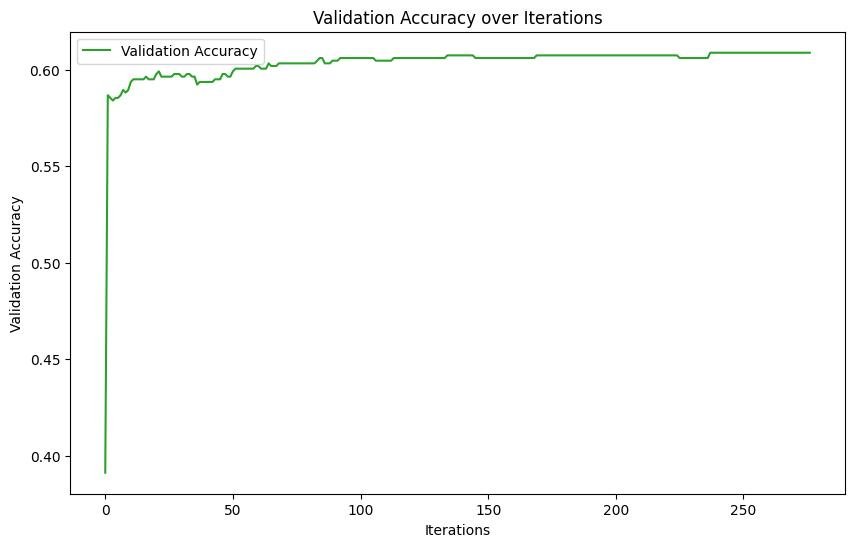

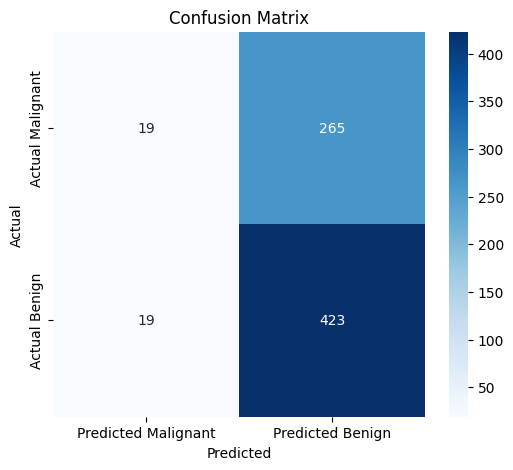

In [50]:
def plot_training_loss(loss_history):
    epochs = range(len(loss_history))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_history, color='tab:blue', label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Iterations')
    plt.legend()
    plt.show()

def plot_validation_accuracy(val_accuracy_history):
    epochs = range(len(val_accuracy_history))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_accuracy_history, color='tab:green', label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy over Iterations')
    plt.legend()
    plt.show()


def plot_confusion_matrix_cm(w, X_val, y_val):
    probabilities = sigmoid(X_val @ w)
    predictions = (probabilities > 0.5).astype(int)

    cm = confusion_matrix(y_val, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Malignant', 'Predicted Benign'],
                yticklabels=['Actual Malignant', 'Actual Benign'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_training_loss(loss_history)
plot_validation_accuracy(val_accuracy_history)
plot_confusion_matrix_cm(w_opt, X_val, y_val)

In [53]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target  # labels (0, 1, 2 for the three classes)

print("Feature Names:", data.feature_names)
print("Target Names:", data.target_names)

Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


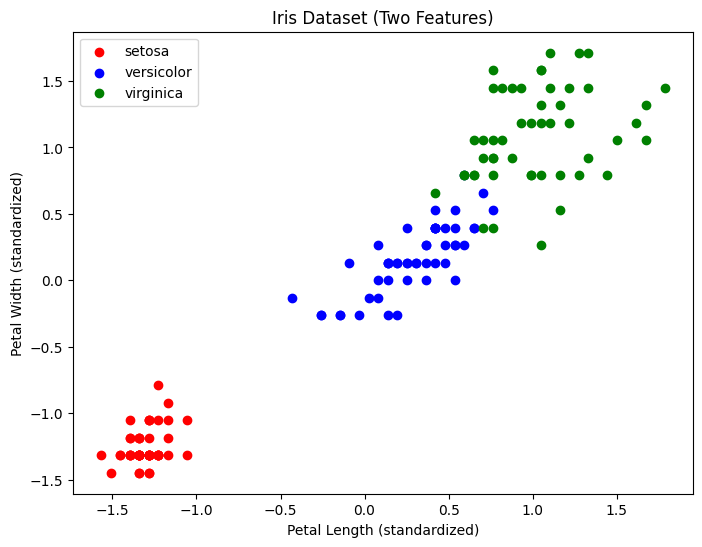

In [54]:
# Select two features: petal length and petal width
feature_indices = [2, 3]  # 0-based indexing
X = X[:, feature_indices]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a bias term (column of ones) to the feature matrix
X_bias = np.hstack((X_scaled, np.ones((X_scaled.shape[0], 1))))

# Plot the standardized data
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
labels = data.target_names

for i in range(len(colors)):
    plt.scatter(X_scaled[y == i, 0], X_scaled[y == i, 1], color=colors[i], label=labels[i])

plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.title('Iris Dataset (Two Features)')
plt.legend()
plt.show()

In [55]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(w, X, y):
    z = X @ w
    predictions = softmax(z)

    # converting labels to one-hot encoding
    y_onehot = np.zeros_like(predictions)
    y_onehot[np.arange(len(y)), y] = 1

    # cross-entropy loss
    epsilon = 1e-15  # to avoid log(0)
    loss = -np.mean(np.sum(y_onehot * np.log(predictions + epsilon), axis=1))
    return loss

def compute_gradient(w, X, y):
    z = X @ w
    predictions = softmax(z)

    # converting labels to one-hot encoding
    y_onehot = np.zeros_like(predictions)
    y_onehot[np.arange(len(y)), y] = 1

    # gradient itself
    errors = predictions - y_onehot
    gradient = X.T @ errors / len(y)
    return gradient

def gradient_descent_multiclass(X, y, learning_rate=0.1, n_steps=10000, tolerance=1e-6):
    n_features = X.shape[1]
    n_classes = np.max(y) + 1  # labels are 0-indexed

    w = np.zeros((n_features, n_classes)) # start with all weights equal to zero
    loss_history = [compute_loss(w, X, y)]
    weights_history = [w.copy()]  # For plotting decision boundaries

    for step in range(1, n_steps + 1):
        grad = compute_gradient(w, X, y)
        w -= learning_rate * grad
        loss = compute_loss(w, X, y)
        loss_history.append(loss)

        # storing weights every 10 steps for visualization
        if step % 10 == 0:
            weights_history.append(w.copy())

        # check for convergence
        if np.abs(loss_history[-2] - loss_history[-1]) < tolerance:
            print(f'Converged at step {step}')
            break

    return w, loss_history, weights_history

Converged at step 9646


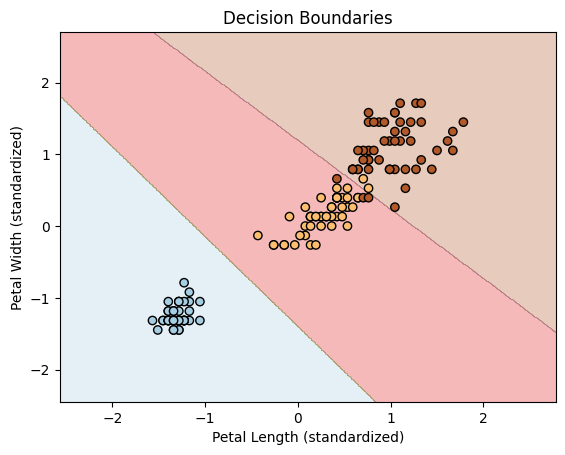

In [56]:
w, loss_history, weights_history = gradient_descent_multiclass(X_bias, y)

# visualize decision boundaries
def plot_decision_boundaries(X, y, w):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    X_grid = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
    Z = np.argmax(softmax(X_grid @ w), axis=1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Petal Length (standardized)')
    plt.ylabel('Petal Width (standardized)')
    plt.title('Decision Boundaries')
    plt.show()

# decision boundaries
plot_decision_boundaries(X_scaled, y, w)

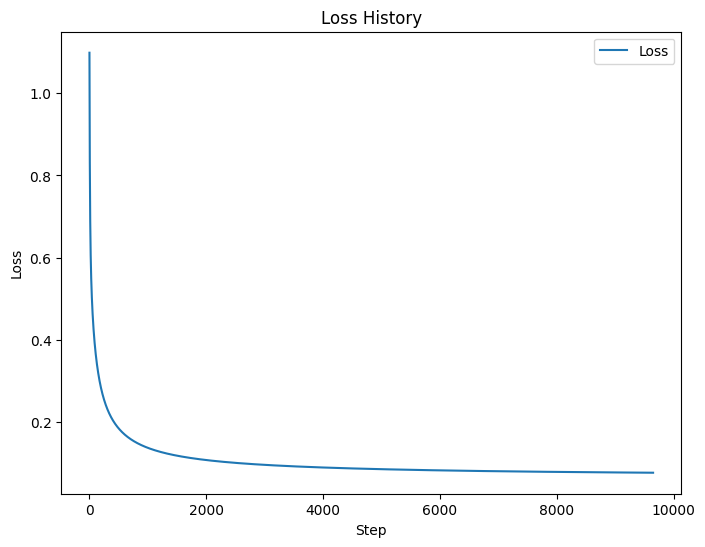

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()